## Import Statements

In [30]:
import numpy as np

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.naive_bayes import GaussianNB, MultinomialNB

import pandas as pd

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

pd.options.mode.chained_assignment = None
# np.random.seed(0)

## Read in Data

In [14]:
data_path = '../Data/'

filenames = [
#     'CM2014_edit.csv',
    'CM2015_edit.csv',
    'CM2016_edit.csv',
    'CM2017_edit.csv',
    'CM2018_edit.csv',
    'mdcp.csv',
    'major_ion.csv',
    'Weather_Data.csv'
]

# cla_2014 = pd.read_csv(data_path + filenames[0], low_memory=False)
cla_2015_raw = pd.read_csv(data_path + filenames[0], low_memory=False)
cla_2016_raw = pd.read_csv(data_path + filenames[1], low_memory=False)
cla_2017_raw = pd.read_csv(data_path + filenames[2], low_memory=False)
cla_2018_raw = pd.read_csv(data_path + filenames[3], low_memory=False)
mdcp_raw = pd.read_csv(data_path + filenames[4], low_memory=False)    # Mendota buoy
weather_raw = pd.read_csv(data_path + filenames[6], error_bad_lines=False, low_memory=False)

## Clean Data

### CLA Data

In [15]:
keep15 = [     # features to keep for years 2015-2017
    'correct_timestamp',
    'collectionSiteId',
    'lake',
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'lat',
    'long'
]

keep18 = [    # features to keep for 2018
    'sample_collection_time',
    'collectionSiteId',
    'lake',
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'latitiude',
    'longitude'
]

rename15 = {   # rename features for 2015-2017
    'collectionSiteId': 'site',
    'lat': 'latitude',
    'long': 'longitude',
    'correct_timestamp': 'date'
}

rename18 = {   # renamce features for 2018
    'collectionSiteId': 'site',
    'sample_collection_time': 'date',
    'latitiude': 'latitude'
}

cla_2015 = cla_2015_raw[keep15]
cla_2016 = cla_2016_raw[keep15]
cla_2017 = cla_2017_raw[keep15]
cla_2018 = cla_2018_raw[keep18]

cla_2015.rename(rename15, axis='columns', inplace=True)
cla_2016.rename(rename15, axis='columns', inplace=True)
cla_2017.rename(rename15, axis='columns', inplace=True)
cla_2018.rename(rename18, axis='columns', inplace=True)

# change data types
numeric = [    # list of numeric features
    'algalBloom',
    'algalBloomSheen',
    'turbidity',
#     'waterTemp',
#     'waveIntensity',
    'latitude',
    'longitude'
]

# convert data types
features = cla_2015.columns.values

for feat in features:
    if feat in numeric:
        cla_2015[feat] = pd.to_numeric(cla_2015[feat], errors='coerce')
        cla_2016[feat] = pd.to_numeric(cla_2016[feat], errors='coerce')
        cla_2017[feat] = pd.to_numeric(cla_2017[feat], errors='coerce')
        cla_2018[feat] = pd.to_numeric(cla_2018[feat], errors='coerce')
    
    if feat in ['site', 'lake']:
        cla_2015[feat] = cla_2015[feat].astype(str)
        cla_2016[feat] = cla_2016[feat].astype(str)
        cla_2017[feat] = cla_2017[feat].astype(str)
        cla_2018[feat] = cla_2018[feat].astype(str)
    
    if feat == 'date':
        cla_2015[feat] = pd.to_datetime(cla_2015[feat], errors='coerce')
        cla_2016[feat] = pd.to_datetime(cla_2016[feat], errors='coerce')
        cla_2017[feat] = pd.to_datetime(cla_2017[feat], errors='coerce')
        cla_2018[feat] = pd.to_datetime(cla_2018[feat], errors='coerce')
        
# remove nans
cla_2015.dropna(axis='rows', how='any', inplace=True)
cla_2016.dropna(axis='rows', how='any', inplace=True)
cla_2017.dropna(axis='rows', how='any', inplace=True)
cla_2018.dropna(axis='rows', how='any', inplace=True)

# remove any data point not on lake mendota
cla_2015 = cla_2015[cla_2015['lake'].str.contains('Mendota')]
cla_2016 = cla_2016[cla_2016['lake'].str.contains('Mendota')]
cla_2017 = cla_2017[cla_2017['lake'].str.contains('Mendota')]
cla_2018 = cla_2018[cla_2018['lake'].str.contains('Mendota')]

# set date as index
cla_2015.set_index('date', inplace=True)
cla_2016.set_index('date', inplace=True)
cla_2017.set_index('date', inplace=True)
cla_2018.set_index('date', inplace=True)

# sort data by dates
cla_2015.sort_values(by='date', inplace=True)
cla_2016.sort_values(by='date', inplace=True)
cla_2017.sort_values(by='date', inplace=True)
cla_2018.sort_values(by='date', inplace=True)

# resample, ffill and bfill
cla_2015 = cla_2015.resample('D').mean()
cla_2015.ffill(inplace=True)
cla_2015.bfill(inplace=True)

for date in cla_2015.index:
    if cla_2015.loc[date, 'algalBloomSheen'] > 0:
        cla_2015.loc[date, 'algalBloomSheen'] = 1

cla_2016 = cla_2016.resample('D').mean()
cla_2016.ffill(inplace=True)
cla_2016.bfill(inplace=True)

for date in cla_2016.index:
    if cla_2016.loc[date, 'algalBloomSheen'] > 0:
        cla_2016.loc[date, 'algalBloomSheen'] = 1

cla_2017 = cla_2017.resample('D').mean()
cla_2017.ffill(inplace=True)
cla_2017.bfill(inplace=True)

for date in cla_2017.index:
    if cla_2017.loc[date, 'algalBloomSheen'] > 0:
        cla_2017.loc[date, 'algalBloomSheen'] = 1

cla_2018 = cla_2018.resample('D').mean()
cla_2018.ffill(inplace=True)
cla_2018.bfill(inplace=True)

for date in cla_2018.index:
    if cla_2018.loc[date, 'algalBloomSheen'] > 0:
        cla_2018.loc[date, 'algalBloomSheen'] = 1
        
# only keep the dates of the official sampling season of each year
# cla_2015 = cla_2015[(cla_2015.index >= '2015-5-19') & (cla_2015.index <= '2015-9-4')]
# cla_2016 = cla_2016[(cla_2016.index >= '2016-5-25') & (cla_2016.index <= '2016-9-4')]
# cla_2017 = cla_2017[(cla_2017.index >= '2017-5-25') & (cla_2017.index <= '2017-9-4')]
# cla_2018 = cla_2018[(cla_2018.index >= '2018-5-25') & (cla_2018.index <= '2018-9-4')]

### MDCP Data

In [16]:
keep_mdcp = [
    'sampledate',
    'sampletime',
    'air_temp',
    'rel_hum',
    'wind_speed',
    'wind_dir',
    'chlor',
    'phycocyanin',
    'do_raw',
    'do_sat',
    'do_wtemp',
    'pco2_ppm',
    'par',
    'par_below'
]

mdcp = mdcp_raw[keep_mdcp]
mdcp.ffill(inplace=True)
mdcp.bfill(inplace=True)

mdcp['date'] = mdcp['sampledate'] + ' ' + mdcp['sampletime']
mdcp['date'] = pd.to_datetime(mdcp['date'], errors='coerce')
mdcp.dropna(axis='rows', how='any', inplace=True)

mdcp = mdcp[[
    'date',
    'air_temp',
    'rel_hum',
    'wind_speed',
    'wind_dir',
    'chlor', 
    'phycocyanin',
    'do_raw',
    'do_sat',
    'do_wtemp',
    'pco2_ppm',
    'par',
    'par_below'
]]
mdcp.set_index('date', inplace=True)

mdcp = mdcp.resample('D').mean()
mdcp.ffill(inplace=True)
mdcp.bfill(inplace=True)

### Weather Data

In [17]:
keep_weather = [
    'DATE',
    'REPORTTPYE',
    'DAILYMaximumDryBulbTemp',
    'DAILYMinimumDryBulbTemp',
    'DAILYAverageDryBulbTemp',
    'DAILYDeptFromNormalAverageTemp',
    'DAILYAverageDewPointTemp',
    'DAILYAverageWetBulbTemp',
    'DAILYPrecip',
    'DAILYAverageStationPressure',
    'DAILYAverageSeaLevelPressure'
]

weather = weather_raw[keep_weather]
# weather['REPORTTPYE'].dropna(axis='rows', how='any', inplace=True)
weather = weather.iloc[:-1]  # remove last entry since it has NaN in REPORTTPYE

weather = weather[weather['REPORTTPYE'].str.contains('SOD')]    # only keep summary of day (SOD) info
weather = weather.drop(['REPORTTPYE'], axis='columns')
weather['DATE'] = pd.to_datetime(weather['DATE'], errors='coerce')

weather.set_index('DATE', inplace=True)
weather = weather.resample('D').ffill()
weather.ffill(inplace=True)
weather.bfill(inplace=True)

## Join CLA, MDCP, and Weather Data

In [18]:
# Append CLA data
cla = cla_2015.append(cla_2016)
cla = cla.append(cla_2017)
cla = cla.append(cla_2018)

# Insert MDCP data
data = cla.join(mdcp, how='inner')

# Insert weather data
data = data.join(weather, how='inner')

# sine/cosine transformation of month of year and wind direction
data['cos_month'] = np.cos(2 * np.pi * (data.index.month.values / 12))
data['sin_month'] = np.sin(2 * np.pi * (data.index.month.values / 12))

data['cos_wind_dir'] = np.cos(2 * np.pi * (data['wind_dir'] / 12))
data['sin_wind_dir'] = np.sin(2 * np.pi * (data['wind_dir'] / 12))
data = data.drop(['wind_dir'], axis='columns')

# Replace 'T' and 's' in 'DAILYPrecip' column
for date in data.index:
    if 'T' in data.loc[date, 'DAILYPrecip']:
        data.loc[date, 'DAILYPrecip'] = 0.01
    elif 's' in data.loc[date, 'DAILYPrecip']:
        data.loc[date, 'DAILYPrecip'] = 0

# Make every feature numeric
for col in data.columns.values:
    if type(data[col].values[0]) != np.float64:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        
# create indicator features for whether there was rain or a bloom one day ago, or within three days or a week ago
precip = (data['DAILYPrecip'] > 0).astype(int)   # convert precipitation to boolean values
data['DAILYPrecip_one_day'] = precip.shift(1)
data['DAILYPrecip_three_day'] = precip.rolling(3).sum()    # NOTE THAT THIS IS DEPENDENT ON CURRENT VALUE
data['DAILYPrecip_one_week'] = precip.rolling(7).sum()

temp = data[['algalBloomSheen']]

data['algalBloomSheen_one_day'] = data['algalBloomSheen'].shift(1)
data['algalBloomSheen_three_day'] = data[['algalBloomSheen']].shift(1).rolling(3).sum()
data['algalBloomSheen_one_week'] = data[['algalBloomSheen']].shift(1).rolling(7).sum()

data.dropna(axis='rows', how='any', inplace=True)

labels = data[['algalBloomSheen']]
data = data.drop(['latitude', 'longitude', 'algalBloom', 'algalBloomSheen'], axis='columns')

## Create Data Loaders

In [185]:
batch_size = 16
num_epochs = 200

X_train = data[data.index.year < 2018].values
X_test = data[data.index.year == 2018].values

y_train = labels[labels.index.year < 2018].values
y_test = labels[labels.index.year == 2018].values

y_train = np.reshape(y_train.astype(int), newshape=(X_train.shape[0]))
y_test = np.reshape(y_test.astype(int), newshape=(X_test.shape[0]))

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).reshape(-1, 1).float())
test_set = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).reshape(-1, 1).float())

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=X_test.shape[0], shuffle=False)

## Define Model

In [186]:
class CLANet(nn.Module):
    def __init__(self, input_size):
        super(CLANet, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(40, 50)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50, 50)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(50, 40)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(40, 30)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(30, 15)
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(15, 2)
        self.soft7 = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        x = self.relu5(x)
        x = self.fc6(x)
        x = self.relu6(x)
        x = self.fc7(x)
        x = self.soft7(x)
        return x

### Instantiate Neural Network

In [187]:
learning_rate = 0.001

weights = torch.Tensor([np.bincount(y_train)[0] / len(y_train), np.bincount(y_train)[1] / len(y_train)])

model = CLANet(X_train.shape[1])
criterion = nn.CrossEntropyLoss(weight=weights)

# opt = torch.optim.SGD(model.parameters(), lr=learning_rate, nesterov=True, momentum=0.7, dampening=0)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8)

## Train CLANet

In [188]:
# Train model
loss_arr = []
acc_arr = []

model.train()

for epoch in range(num_epochs):
    print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    
    epoch_loss_arr = []
    epoch_acc_arr = []
    
    for samples, target in train_loader:
        opt.zero_grad()
        output = model(samples)
        loss = criterion(output, target.squeeze(1).long())
        
        _, pred = torch.max(output, 1)
                
        loss.backward()
        opt.step()
        
        epoch_loss_arr.append(loss.item())
        epoch_acc_arr.append(torch.sum(pred == target.squeeze(1).long()).float() / len(target))
    
    epoch_loss = sum(epoch_loss_arr)
    epoch_acc = sum(epoch_acc_arr) / 100
    
    loss_arr.append(epoch_loss)
    acc_arr.append(epoch_acc)
    
    print('Loss: {:0.4f} Acc: {:0.4f}'.format(epoch_loss, epoch_acc))
    
    if epoch == 99:
        for param_group in opt.param_groups:
            param_group['lr'] = 0.0001


Epoch 1/200
----------
Loss: 21.9113 Acc: 0.0806

Epoch 2/200
----------
Loss: 17.5240 Acc: 0.2219

Epoch 3/200
----------
Loss: 14.1029 Acc: 0.2194

Epoch 4/200
----------
Loss: 14.0940 Acc: 0.2194

Epoch 5/200
----------
Loss: 13.9512 Acc: 0.2194

Epoch 6/200
----------
Loss: 13.7070 Acc: 0.2194

Epoch 7/200
----------
Loss: 13.4795 Acc: 0.2194

Epoch 8/200
----------
Loss: 13.2749 Acc: 0.2225

Epoch 9/200
----------
Loss: 13.0832 Acc: 0.2375

Epoch 10/200
----------
Loss: 12.8756 Acc: 0.2475

Epoch 11/200
----------
Loss: 12.6243 Acc: 0.2550

Epoch 12/200
----------
Loss: 12.3508 Acc: 0.2587

Epoch 13/200
----------
Loss: 12.1015 Acc: 0.2619

Epoch 14/200
----------
Loss: 12.2779 Acc: 0.2575

Epoch 15/200
----------
Loss: 12.2734 Acc: 0.2606

Epoch 16/200
----------
Loss: 12.4510 Acc: 0.2519

Epoch 17/200
----------
Loss: 12.1475 Acc: 0.2625

Epoch 18/200
----------
Loss: 12.1085 Acc: 0.2550

Epoch 19/200
----------
Loss: 11.7912 Acc: 0.2656

Epoch 20/200
----------
Loss: 11.5967 A

Loss: 11.1376 Acc: 0.2725

Epoch 162/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 163/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 164/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 165/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 166/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 167/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 168/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 169/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 170/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 171/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 172/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 173/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 174/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 175/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 176/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 177/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 178/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 179/200
----------
Loss: 11.1376 Acc: 0.2725

Epoch 180/200
----------
Loss: 11.137

### Plot Training Performance

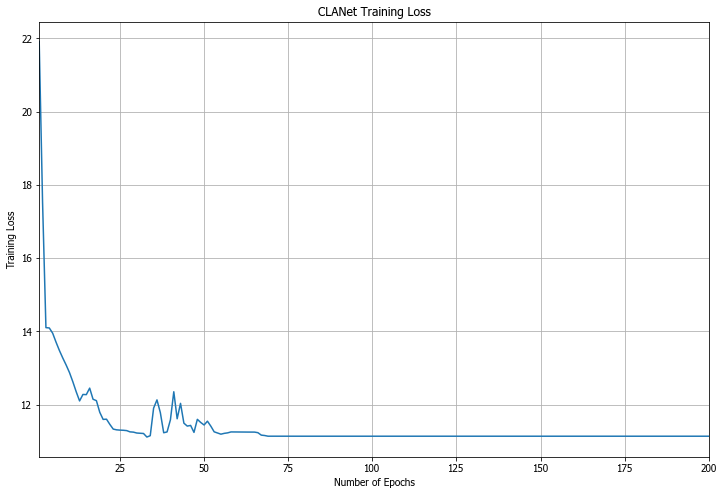

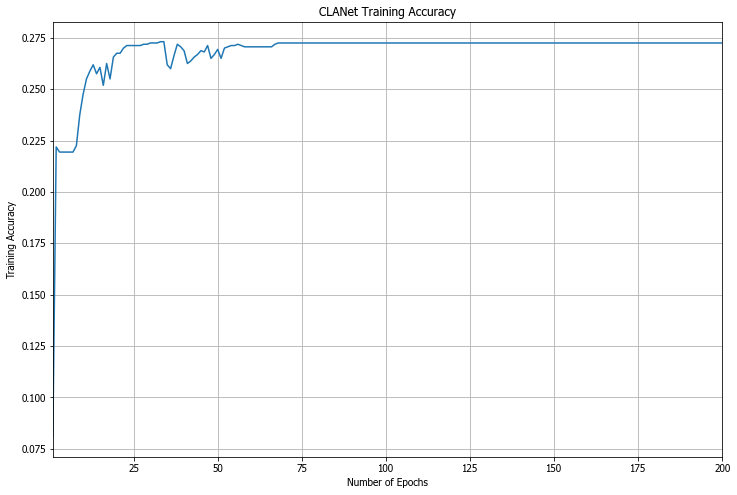

In [189]:
x = [i for i in range(1, num_epochs+1)]

plt.figure(figsize=(12, 8))
plt.plot(x, loss_arr)
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')
plt.title('CLANet Training Loss')
plt.xlim([1, num_epochs])
plt.grid(True)

plt.figure(figsize=(12, 8))
plt.plot(x, acc_arr)
plt.xlabel('Number of Epochs')
plt.ylabel('Training Accuracy')
plt.title('CLANet Training Accuracy')
plt.xlim([1, num_epochs])
plt.grid(True)

In [168]:
# Test model
model.eval()

for samples, target in test_loader:
    opt.zero_grad()
    output = model(samples)
    loss = criterion(output, target.squeeze(1).long())

    _, pred = torch.max(output, 1)
    
acc = torch.sum(pred == target.squeeze(1).long()).float() / len(target)
conf_matrix = confusion_matrix(target.numpy(), pred.numpy(), labels=[0, 1])

print('\nTest Accuracy: {:0.4f}'.format(acc))
print('Confusion Matrix:')
print(pd.DataFrame(conf_matrix))
print('\n\n')


Test Accuracy: 0.5786
Confusion Matrix:
    0   1
0  73   5
1  62  19



